# LTEM Image Simulation Example
This notebook gives examples of how to simulate and reconstruct LTEM images from a given magnetization. The first section presents an all-in-one function that takes a magnetization vector output file, the various materials and imaging parameters, and returns a TIE reconstructed image set.  

The following sections breaks down the process into the components: magnetization images $\rightarrow$ phase shift $\rightarrow$ LTEM images $\rightarrow$ reconstructed magnetizations.
  
Authors: Arthur McCray, CD Phatak
V1.0, ANL, May 2020

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import numpy as np
import sys 
sys.path.append("../PyTIE/")
from TIE_helper import *
from sim_helper import *
from TIE_reconstruct import TIE, SITIE
from comp_phase import mansPhi, linsupPhi

# Simulating from Micromagnetics Output 
reconstruct_ovf() is a single function that begins with a micromagnetics vector output file (.omf or .ovf) and simulates then reconstructs a LTEM through focus series (tfs). There are many parameters that need to be set falling into two primary categories: materials parameters and imaging conditions. 

### Materials Parameters
While the physical dimensions of the sample and voxel size are given in the datafile header, other material parameters are not. Additionally, for practical purposes many samples will be on a substrate or membrane of some sort which we can account for (while assuming it is of uniform thickness). Here we specify: 
* file: The file path. This function can load OVF 2.1/2.0 text files and most binaries as well, though it seems to fail with some binaries output from NanoHub.
* sim: The simulation software used. Outputs from OOMMF and mumax require different scaling. Expects one of the following inputs: 
    - 'oommf': Assumes values given in A/m - scales by mu0
    - 'mumax': Assumes vectors are normalized - scales by Msat
    - 'raw': Does not scale vectors. 
* Msat: The saturation magnetization in gauss. 
* sample_V0: The sample mean inner potential in volts. 
* sample_xip0: The extinction distance for the sample in nm. 
* mem_thk: The thickness of the membrane in nm. 
* mem_xip0: The extinction distance for the membrane in nm. 
* calc_region: An option for only calculating the phase shift through part of the image. The phase shift calculation is the speed-limiting step of this process, and here you can give a binary array (of the same size as your magnetization array) that will mask for which voxels are calculated. Default None will have the phase shift calculated through full array. 
* thk_map: 2D array of size (y,x) which scales the thickness of the sample. A value of 1 at any pixel will give a thickness equal to znodes\*zstepsize (the thickness given by the data file) at that pixel. Default None will give the sample a uniform thickness as given by the datafile. 

In [167]:
# file = "../../ex_recon_data/ex_omf_1/5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05-Oxs_TimeDriver-Magnetization-07-0002140.omf"
# sim = 'oommf'

file = "C:/Users/arthu/Desktop/m000004.ovf"
sim = 'mumax'

Msat = 1e4 # gauss
sample_V0 = 10 # V
sample_xip0 = 50 # nm
mem_thk = 50 # nm
mem_xip0 = 1000 # nm
calc_region = None # defaults to full image
thk_map = None # defaults to uniform thickness from the datafile. 

### Imaging conditions
The final reconstruction is dependent on both the imaging conditions as well as the microscope itself. Microscope parameters are contained in a Microscope object (named pscope in the example below), making it easy to compare results in different simulated microscopes.  
Parameters (the default value is given for parameters where it might often be used): 
- defval: The defocus at which to simulate images in nm (in-focus and +/- defval will be used for the tfs)
- theta_x: The sample tilt around the x-axis (degrees). Default 0. 
- theta_y: The sample tilt around the y-axis (degrees). Default 0. 
- add_random: Whether to account for amorphous background in the sample. 1 provides a small amount of background and other float values can be used to increase/decrease the intensity. Default 0. 
- flip: Whether to use a single tfs (False) or calculate a tfs for the sample in both orientations. For flat samples a single tfs is fine, though it's needed for samples with variable thickness (which can be controlled with the thk_map array). Default True. 

In [126]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0, verbose=True)
defval = 50_000 # nm
theta_x = 0 # degrees
theta_y = 0 # degrees
add_random = 1 # scaling factor
flip=True # Bool

Creating a new microscope object with the following properties:
Quantities preceded by a star (*) can be changed using optional arguments at call.
-------------------------------------------------------------------------
*Accelerating voltage              E: [V]        2e+05
*Spherical Aberration             Cs: [nm]       2e+05
*Chromatic Aberration             Cc: [nm]       5e+06
*Beam Coherence              theta_c: [rad]      1e-05
*2-fold astigmatism               Ca: [nm]       0
*2-fold astigmatism angle      phi_a: [rad]      0
*defocus spread              def_spr: [nm]       80
Electron wavelength           lambda: [nm]       0.002508
Relativistic factor            gamma: [-]        1.391
Interaction constant           sigma: [1/V/nm]   0.007288
-------------------------------------------------------------------------


### Calculation Parameters and Run

Finally there are some parameters that control the outputs given. 
* savename: String that will prepend all saved files.
* save: Integer to control the amount of output that is saved; if saving, images and parameters files will be saved to subdirectories of wherever the datafile is located. "/sim_tfs/" will contain the tfs of the unflip and flip simulated images and a params.txt file with basic simulation parameters. "/images/" will contain TIE reconstruction output images. 
    - 0: Saves nothing, still returns results. 
    - 1: Default. Saves simulated images, simulated phase shift, and reconstructed magnetizations as both a color image and x/y components. 
    - 2: Saves simulated images, simulated phase shift, and all reconstruction TIE images. 
* v: Verbosity
    - 0: Suppress all output
    - 1: Default. Standard output with progress on phase shift calculations and displaying resulting image. 
    - 2: Extended output. Prints full datafile header and shows simulated phase shifts and tfs. 


In [ ]:
savename = 'Vuk_example'
save=2
v=2

results = reconstruct_ovf(file=file, sim=sim, save=save, savename=savename, v=v, 
                          flip=flip, pscope=pscope, defval=defval, 
                          theta_x=theta_x, theta_y=theta_y, add_random=add_random, 
                          calc_region=calc_region, thk_map=thk_map,
                          Msat=Msat, sample_V0=V0, sample_xip0=sample_xip0, 
                          mem_thk=mem_thk, mem_xip0=mem_xip0)

-----Start .ovf Header:-----
# OOMMF OVF 2.0
# Segment count: 1
# Begin: Segment
# Begin: Header
# Title: m
# meshtype: rectangular
# meshunit: m
# xmin: 0
# ymin: 0
# zmin: 0
# xmax: 2.2e-05
# ymax: 2.2e-05
# zmax: 2e-08
# valuedim: 3
# valuelabels: m_x m_y m_z
# valueunits: 1 1 1
# Desc: Total simulation time:  0  s
# xbase: 1.07421875e-08
# ybase: 1.07421875e-08
# zbase: 2.5e-09
# xnodes: 1024
# ynodes: 1024
# znodes: 4
# xstepsize: 2.1484375e-08
# ystepsize: 2.1484375e-08
# zstepsize: 5e-09
# End: Header
# Begin: Data Binary 4
------End .ovf Header:------

Binary 4 file found
Simulation size (z, y, x) : (4, 1024, 1024)
Image (x-y) scale : 21.5 nm/pixel.
Out-of-plane (z) scale : 5 nm/pixel.
little endian
Scaling for mumax datafile with Msat=1e+04.
Beginning phase calculation for 4.1943e+06 voxels.
0.00%
0.00%
0.00%
0.01%
0.01%
0.01%
0.01%
0.01%
0.02%
0.02%
0.02%
0.02%
0.03%
0.03%
0.03%
0.03%
0.03%
0.04%
0.04%
0.04%
0.04%
0.05%
0.05%
0.05%
0.05%
0.05%
0.06%
0.06%
0.06%
0.06%
0.07%
0.

### Comparing to the raw magnetization data: 

In [ ]:
from colorwheel import color_im
show_im(color_im(np.sum(mag_x, axis=0), np.sum(mag_y,axis=0),hsvwheel=True), "Raw magnetization data from file")

<IPython.core.display.Javascript object>


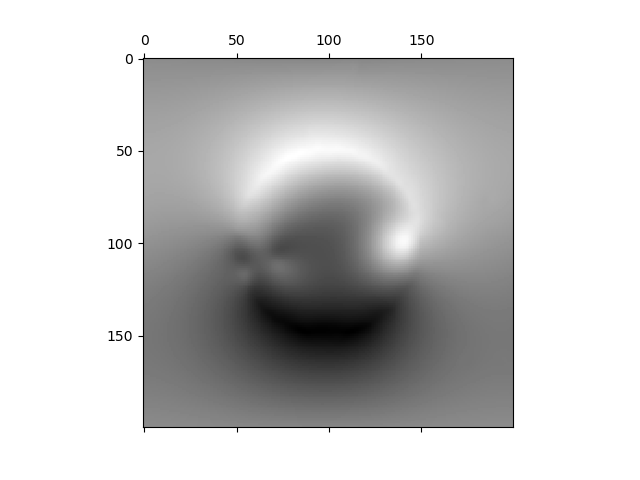

In [165]:
show_im(results['phase_m'])

<IPython.core.display.Javascript object>


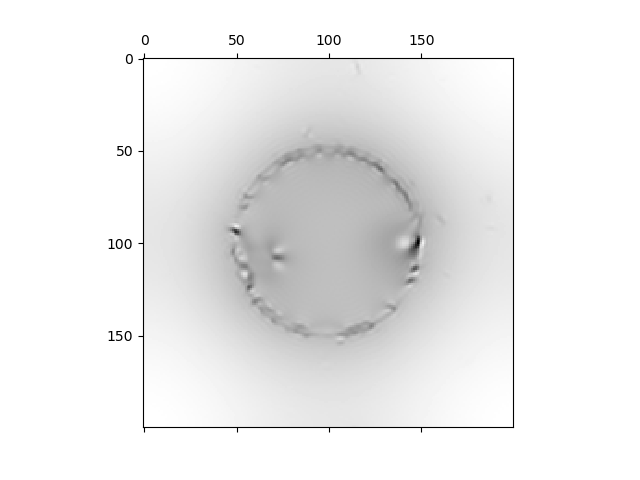

In [166]:
show_im(results['phase_e'])

# Individual Simulation Components
Here we show how to use the individual components of the simulation. Simple constructed vortex states are used rather than a large 

## Calculating the phase shift from a Bloch vortex with the Mansuripur algorithm  
This can only be applied to 2D magnetizations. For more details seee [this paper by Mansuripur](https://doi.org/10.1063/1.348682).   
It can be applied easily to island structures using the shape argument which takes a 2D binary array.  
std_mansPhi is for a a basic example with fixed materials parameters, but for most work one should call mansPhi directly. 

<IPython.core.display.Javascript object>


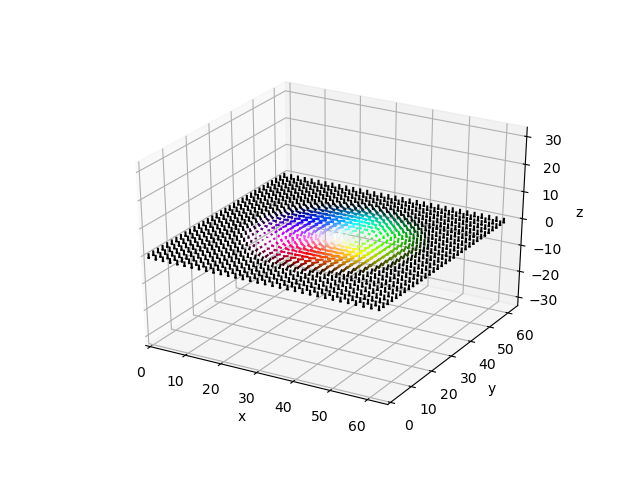

<IPython.core.display.Javascript object>


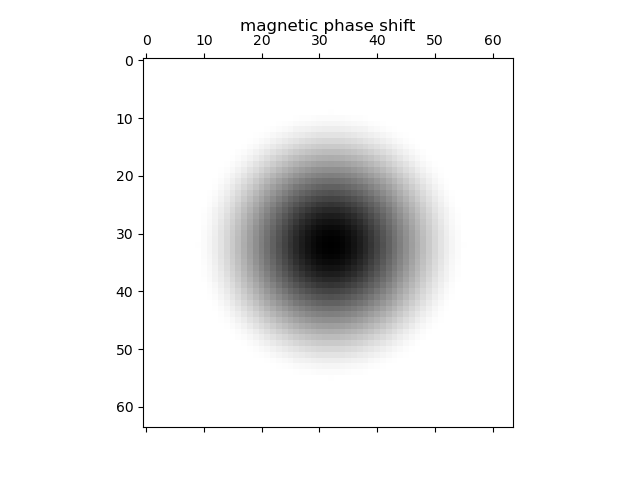

In [110]:
dim = 64
del_px = 10 # nm/pixel
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)
show_3D(Bloch_x, Bloch_y, Bloch_z, show_all = True, l=2, a = 50)

# Apply mansuripur algorithm with some standard materials parameters. 
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, del_px = del_px)
show_im(mphi, title="magnetic phase shift")

### Simulating LTEM images from the phase shift

Total fov is (640,640) nm


<IPython.core.display.Javascript object>


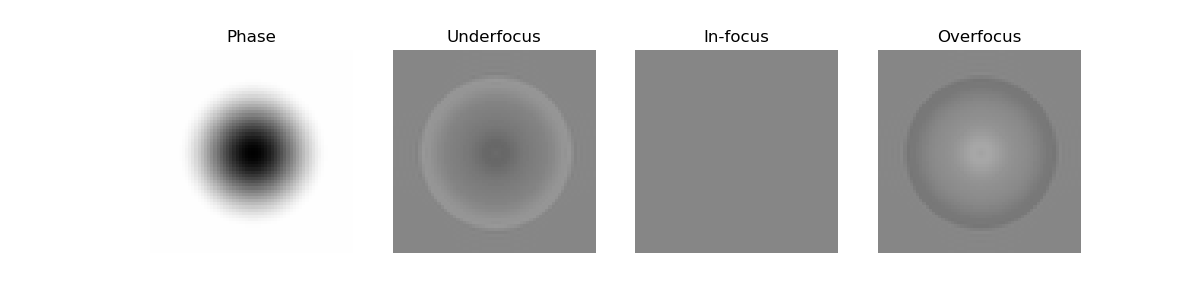

In [111]:
# Simulate LTEM images
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
defval = 50_000
Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi, ephi=ephi, 
                                       pscope=pscope,
                                       del_px=del_px, 
                                       def_val=defval)
show_sims(Tphi, im_un, im_in, im_ov)

## Getting magnetic and electrostatic phase shift with the linear superposition method  
This method works with 3D magnetization structures but is slower. 

In [119]:
del_px = 10 # nm/pix
b0 = 1e4 #Gauss default 1e4
phi0 = 2.07e7 #Gauss*nm^2 
cb = b0/phi0*del_px**2 #1/px^2
pre_B = 2*np.pi*cb
ephi_L, mphi_L = linsupPhi(mx=Bloch_x.reshape(1,dim,dim),
                           my=Bloch_y.reshape(1,dim,dim),
                           mz=Bloch_z.reshape(1,dim,dim), 
                           Dshp=np.ones(Bloch_z.reshape(1,dim,dim).shape), 
                           pre_B=pre_B)

nelems =  4096
0.00%
100.00%


Total fov is (640,640) nm


<IPython.core.display.Javascript object>


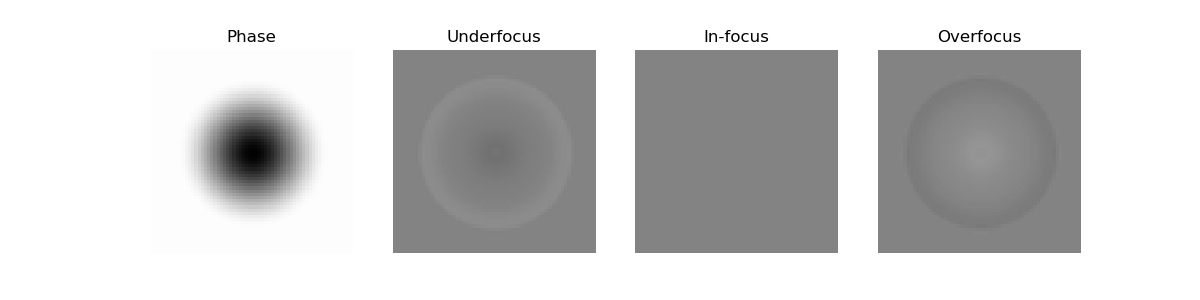

In [120]:
# Simulate LTEM images
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
defval = 50_000
Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi_L, ephi=ephi_L, 
                                       pscope=pscope,
                                       del_px=del_px, 
                                       def_val=defval)
show_sims(Tphi, im_un, im_in, im_ov)

# Full example simulating and reconstructing images from a given magnetization

In [ ]:
# slightly larger image this time, using Mansuripur algorithm for speed
# and adding amorphous background contributions
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
dim = 512
del_px = 500/dim

Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True)
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, del_px = del_px, pscope=pscope)

defval = 100_000
Tphi, im_un, im_in, im_ov = sim_images(mphi = mphi, ephi = ephi, 
                                       pscope = pscope,
                                       del_px = del_px, 
                                       def_val = defval,
                                       add_random = 1)


In [ ]:
show_sims(Tphi, im_un, im_in, im_ov)

### Reconstructing with full TIE  
Uniformly thin film, so no need for a flip stack. 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie = TIE_params(imstack=[im_un, im_in, im_ov], defvals=[defval], flip=False, no_mask=True)
ptie.set_scale(del_px)

i = 0 
dataname = f'Example_Bloch' 
sym = False
qc = False
save = False

results = TIE(i, ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

#### Comparing the reconstructed phase to the simulated values
If this sample were not simulated as being uniformly flat (which we could do using the isl_shape parameter), we would have needed to calculate a flip stack by simulating images with ephi=ephi and mphi=-1\*mphi, and done a full TIE reconstruction with the unflip and flip stacks. 

In [ ]:
# (total phase shift reconstructed) / (magnetic phase shift simulated)
(np.max(results["phase_m"])-np.min(results["phase_m"]))/(np.max(mphi)-np.min(mphi))

### Single Image TIE (SITIE) Reconstruction 
Example showing how this magnetization can be reconsutructed from a single image.  
This can be applied to experimental images that are uniformly flat, thin, and with only magnetic contrast.  
For more information see [this paper by Chess et. al](https://doi.org/10.1016/j.ultramic.2017.02.004). 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie_SITIE = TIE_params(im_ov, [], defval)
ptie_SITIE.set_scale(del_px)

dataname = 'Example_SITIE_Bloch' 
sym = False
qc = False
save = False

results = SITIE(ptie_SITIE, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

#### This can also be done with the original ptie, selecting image with an index from the imstack. 

In [ ]:
results = SITIE(ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save,
                     i=0) # for i=1 will try to reconstruct the infocus image and won't work. 

## Examples creating single layer skyrmion magnetization structures
You can click and drag to turn the show3D figures. 

In [ ]:
dim = 64
Bloch_x2, Bloch_y2, Bloch_z2 = Lillihook(dim, Q = 1, gamma=3*np.pi/2)
show_3D(Bloch_x2, Bloch_y2, Bloch_z2, show_all = True, l=2, a = 50)

In [ ]:
anti_x, anti_y, anti_z = Lillihook(dim, rad=dim//4, Q = -1, show=False)
show_3D(anti_x, anti_y, anti_z, show_all = False, l=5, a = 25)
show_2D(anti_x, anti_y, l=3, a = 50)

--- End Notebook ---